# Visualizing Multiple Contrasts

> Explanation of how to use forest_plot for contrast objects e.g delta-delta and mini-meta or regular deltas.

- order: 11

In DABEST **XXX**, we introduce two new ways of visualizing bootstrap distributions in more compact ways:
- forest plot
- vortexmap

## Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import dabest
from dabest.multi import combine, vortexmap

## Create a simulated dataset and generate a list of corresponding dabest objects

In [ ]:
def create_delta_dataset(N=20, 
                        seed=9999, 
                        second_quarter_adjustment=3, 
                        third_quarter_adjustment=-0.1,
                        scale2=1, initial_loc = 3):
    """Create a sample dataset for delta-delta analysis."""
    np.random.seed(seed)

    # Create samples
    y = norm.rvs(loc=initial_loc, scale=0.4, size=N*4)
    y[N:2*N] = norm.rvs(loc=initial_loc + second_quarter_adjustment, scale=scale2, size=N) 
    y[2*N:3*N] = norm.rvs(loc=initial_loc + third_quarter_adjustment, scale=0.4, size=N)
    y[3*N:4*N] = norm.rvs(loc=initial_loc, scale=0.4, size=N)

    # Treatment, Rep, Genotype, and ID columns
    treatment = np.repeat(['Placebo', 'Drug'], N*2).tolist()
    genotype = np.repeat(['W', 'M', 'W', 'M'], N).tolist()
    id_col = list(range(0, N*2)) * 2

    # Combine all columns into a DataFrame
    df = pd.DataFrame({
        'ID': id_col,
        'Genotype': genotype,
        'Treatment': treatment,
        'Tumor Size': y
    })

    return df

## Working with many many Dabest objects
Let's say you have a transcriptomics experiment where you investigate the effects of altering 6 genes on transcripts 1 to 10. You may simulate the data as follows:

In [ ]:
dabest_objects_2d = [[None for _ in range(10)] for _ in range(6)]
labels_2d = ["Tx 1", "Tx2", "Tx3", "Tx4", "Tx5", "Tx6", "Tx7", "Tx8", "Tx9" , "Tx10"]
row_labels_2d = ["Geno A", "Geno B", "Geno C", "Geno D", "Geno E", "Geno F"]
second_quarter_adjustment_2d = [[.9, 0, 1, .5, 1.2, -1, 0,0, 0, .4], 
             [1, 0, 2, 1, 1, -1, 0,0, 1.5, .4],
             [1, 0, 1, 2, 1, 3, .5,0, -1.2, .4],
             [1.1, 0, 2, 1, 1.4, -0.5, 0,1.1, 3, .4],
             [1, 0, 2, 1.5, -1, -0.5, 0,0, 1, .4],
             [-.3, 0, 2, .7, 1, -0.5, 0,0, 2.3, -.4],
                                ]
scale2_2d = [[1, 10, 1, 1000, 1, 2, 1,1, 0, .4], 
             [1, 0, 8, 3, 1, 4, 7,1, 1000, 2],
             [15, 3, 1, 2, 1, 1, 90,1, 7, 2],
             [1, 0, 1, 330, 1, 6,1,1, 3, .4],
             [90, 0, 700, 1, 1, 2,1,1, 90, .4],
             [1, 0, 1, 4, 1, 4,1,1, 3, .4],
             ]
seeds = [1, 1000, 20, 9999, 109, 5320]

for i in range(len(row_labels_2d)):
    for j in range(len(labels_2d)):
        df = create_delta_dataset(seed=seeds[i], 
                                  second_quarter_adjustment=second_quarter_adjustment_2d[i][j],
                                  third_quarter_adjustment=-0.1, 
                                 initial_loc = 0)
        dabest_objects_2d[i][j] = dabest.load(data=df, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")



For later demo, we are going to create a new object called MultiContrast.

In [ ]:
multi_2d = combine(dabest_objects_2d, labels_2d, row_labels=row_labels_2d, effect_size="hedges_g")
print(multi_2d)

/Applications/anaconda3/envs/vortexmap/lib/python3.10/site-packages/dabest/_effsize_objects.py:306: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(
/Applications/anaconda3/envs/vortexmap/lib/python3.10/site-packages/dabest/_effsize_objects.py:306: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(


MultiContrast(2D: 6x10, effect_size='hedges_g', contrast_type='delta2')


This data would require stacks of forest plots to visualize.

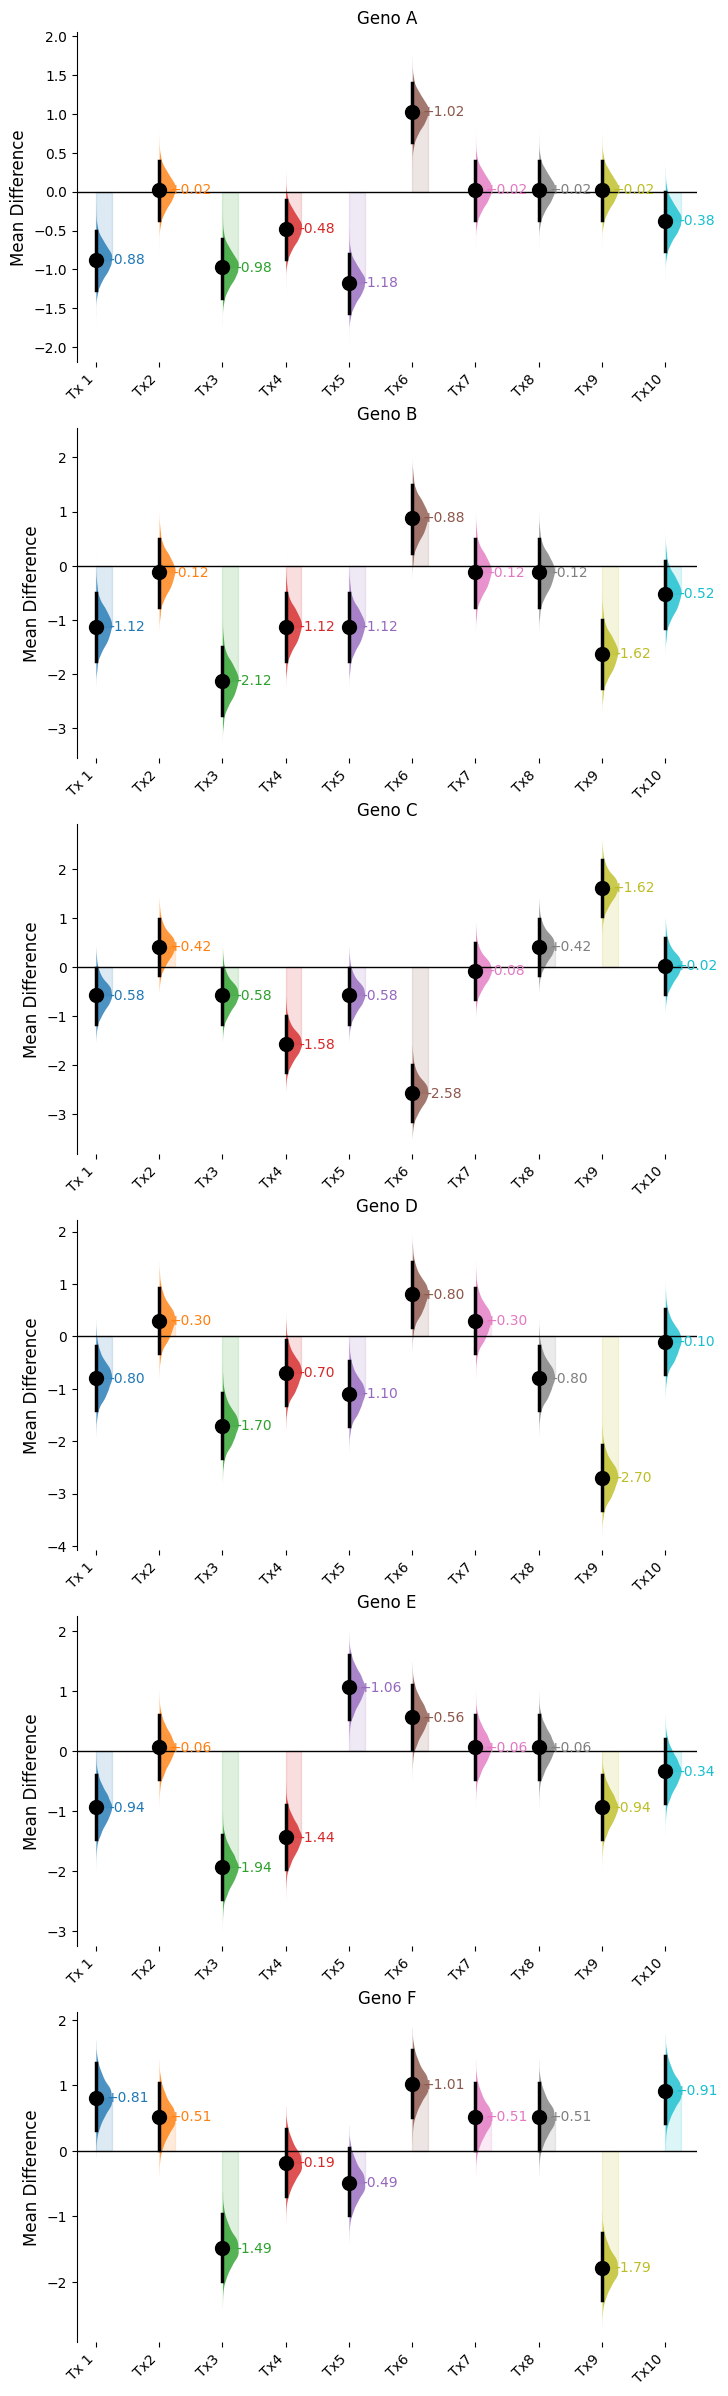

In [ ]:
multiforest, axes = plt.subplots(6, 1, figsize=(8, 30))
for i in range(6):
    multi_1d = combine(dabest_objects_2d[i], labels_2d, effect_size="hedges_g")
    fig_forest = multi_1d.forest_plot(
        effect_size="mean_diff",
        ci_type="bca",  labels = labels_2d, ax = axes[i]
    )
    axes[i].set_title(row_labels_2d[i])


 So instead, we plot a vortexmap for a concise representation: Multicontrast objects present advantages especially when it comes to 2-D arrays of dabest objects. 

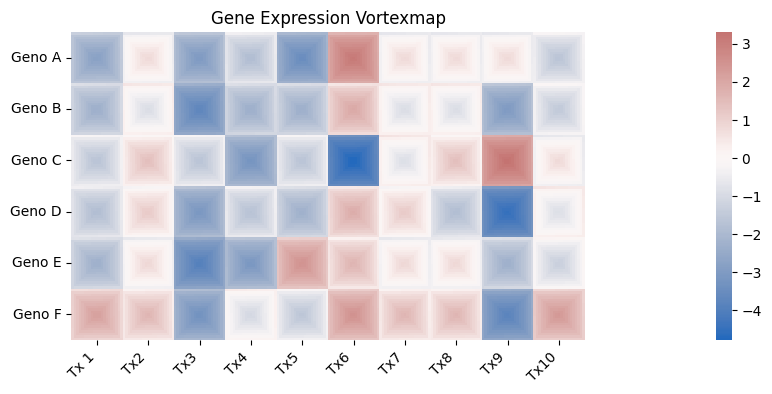

In [ ]:

fig, ax, mean_delta = vortexmap(
    multi_2d,
    n=21,  # Larger spiral size
    vmax=None, vmin=None,  # Extended color range
    reverse_neg=True,
    abs_rank=False,
    chop_tail=5,  # Remove 5% extreme values
    fig_size = (10, 4)
)
plt.title("Gene Expression Vortexmap")
plt.show()


## MultiContrast object can also handle 1-D dabest object arrays

In [ ]:
df_drug1 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.5)
df_drug2 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-1)
df_drug3 = create_delta_dataset(seed=9999, second_quarter_adjustment=2, third_quarter_adjustment=-0.5)
df_drug4 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.1, scale2=7)
df_drug5 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-0.3, scale2=7)

dabest_obj1 = dabest.load(data=df_drug1, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")

dabest_obj2 = dabest.load(data=df_drug2, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")

dabest_obj3 = dabest.load(data=df_drug3, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")

dabest_obj4 = dabest.load(data=df_drug4, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")

dabest_obj5 = dabest.load(data=df_drug5, 
                       x=["Genotype", "Genotype"], 
                       y="Tumor Size", 
                       delta2=True, 
                       experiment="Treatment")

dabest_objs = [dabest_obj1, dabest_obj2, dabest_obj3, dabest_obj4, dabest_obj5]
dabest_objs2 = [[dabest_obj1, dabest_obj2, dabest_obj3, dabest_obj4, dabest_obj5], [dabest_obj1, dabest_obj2, dabest_obj3, dabest_obj4, dabest_obj5]]


multi_1d = combine(dabest_objs, labels=["Drug1", "Drug2", "Drug3", "Drug4", "Drug5"], )
print(multi_1d)

MultiContrast(1D: 1x5, effect_size='mean_diff', contrast_type='delta2')


## You can plot a forest plot from this MultiContrast object

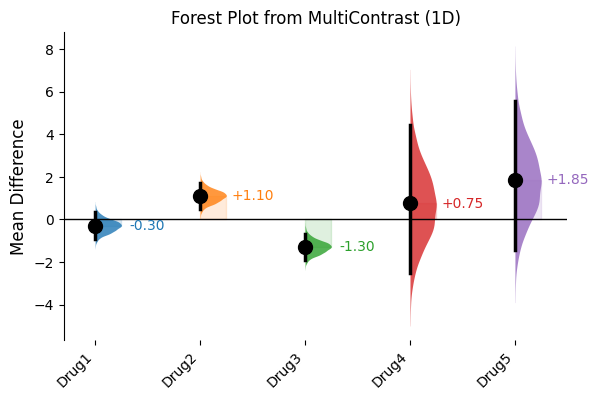

In [ ]:
fig_forest = multi_1d.forest_plot(
    effect_size="mean_diff",
    ci_type="bca", labels=["Drug1", "Drug2", "Drug3", "Drug4", "Drug5"]
)
plt.title("Forest Plot from MultiContrast (1D)")
plt.show()

## 1-D vortexmap also works

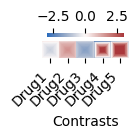

In [ ]:
fig, ax, mean_delta = vortexmap(
    multi_1d,
    n=30,  # Larger spiral size
    vmax=3, vmin=-3,  # Extended color range
    reverse_neg=True,
    abs_rank=False,
    chop_tail=5  # Remove 5% extreme values
)
# plt.title("Customized Vortexmap")
plt.show()